# Data Structure
Data has been downloaded from Moodle and OneDrive for this to work
 - Moodle data is stored in                 data/cmbi_data_control  : eg, first file is data\cmbi_data_control\case01-mask.nii.gz
 - OneDrive data (over 2GB) is stored in    data/EPICure_qt2        : eg, first file is data\EPICure_qt2\Epicure11610-mask1.nii.gz

In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import utils_fc as utils
from tqdm import tqdm



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
data_root = 'data/EPICure_qt2/'
cmap = 'gray'
roi_dict = {"brain":0,"CSF":1,"GM":2,"WM":3,"DeepGM":4,"brainstem":5}
roi_id_dict = {0:'brain', 1:'CSF', 2:'GM', 3:'WM', 4:'DeepGM', 5:'brainstem'}
roi_all_indx = [1,2,3,4,5]
slice_default = 25
seed = 42
rng = np.random.default_rng(seed=seed)

In [15]:
# start loading data
data_loader = utils.MRIDataLoader(data_root)
subject_ids = data_loader.get_subject_ids()
id_default = 1 # 133, 22 is funky
thresh_default = 0.9
TE_times = data_loader.get_TE_times()

plt some examples of MRI data

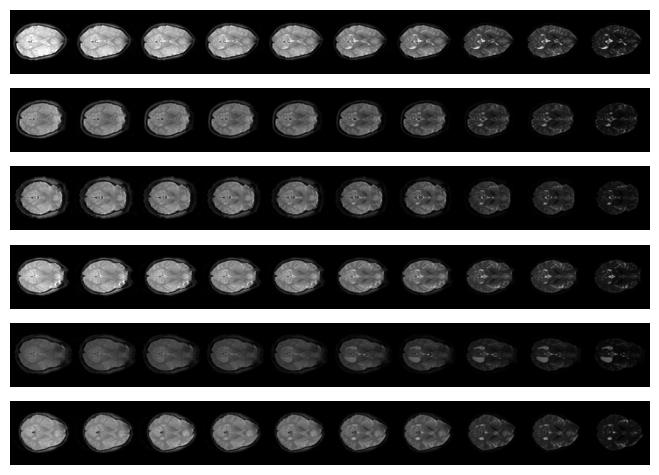

In [16]:
num_subjects = 6
subjects_random = rng.integers(subject_ids.shape[0], size=num_subjects)
fig, axs = plt.subplots(num_subjects, TE_times.shape[0])
# fig.suptitle(f'{num_subjects} Subjects MRI Scans through Time')

imgs = []
img_segs = []
for i, id in enumerate(subjects_random):
    imgs.append(data_loader.get_img(id, 'qt2'))

for i in range(num_subjects):
    img = imgs[i]
    vmax = np.max(img)
    for t in range(TE_times.shape[0]):
        axs[i, t].imshow(img[:,:,slice_default,t], cmap=cmap, vmax=vmax/3)
        axs[i, t].axis('off')

fig.tight_layout(pad=0)

### superimpose segmentations ontop

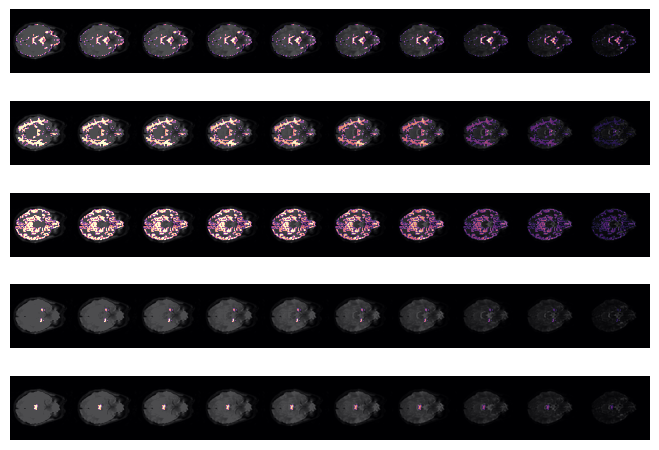

In [17]:
slice_default = 20

id = subjects_random[0]
rois = ["CSF","WM","GM","DeepGM","brainstem"]
thresh = 0.9

num_rois = len(rois)
fig, axs = plt.subplots(num_rois, TE_times.shape[0])

img = data_loader.get_img(id, 'qt2')
seg = data_loader.get_img(id, 'qt2_seg1')
vmax = np.max(img)

for i, roi in enumerate(rois):
    for t in range(TE_times.shape[0]):
        img_seg = img[:,:,slice_default,t]
        seg_roi = seg[:,:,slice_default,roi_dict[roi]]
        img_seg = np.where(seg_roi > thresh, img_seg, 0)
        axs[i,t].imshow(img[:,:,slice_default,t], vmax=vmax/4, cmap='gray')
        axs[i,t].imshow(img_seg, vmax=vmax/5, cmap='magma', alpha=0.7)
        axs[i, t].axis('off')

fig.tight_layout(pad=0)
plt.show()

### plot a few voxels signal from each region

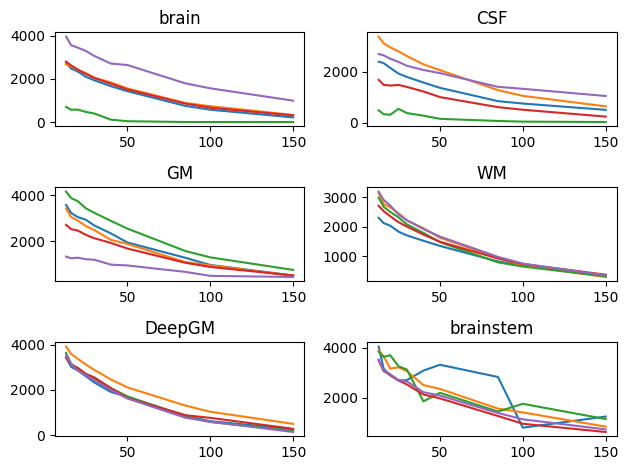

In [18]:
nb_rand_vox = 5

mri_data = data_loader.get_img(id_default, 'signal')
mask_data = data_loader.get_img(id_default, 'mask')
seg_data = data_loader.get_img(id_default, 'seg')

signals_segs = []

signals_brain = mri_data[mask_data == 1, :]

for seg_id in range(len(roi_dict)):
    signals_segs.append(mri_data[seg_data[:,:,:,seg_id] > thresh_default, :])

fig, axs = plt.subplots(3, 2)

for ax_id, ax in enumerate(fig.axes):
    roi = roi_id_dict[ax_id]
    signals_seg = signals_segs[ax_id]
    nb_seg = signals_seg.shape[0]
    rand_vox_ids = rng.integers(low=0, high=nb_seg, size=nb_rand_vox)
    for vox_id in rand_vox_ids:
        ax.plot(TE_times, signals_seg[vox_id])
        ax.set_title(roi)

plt.tight_layout()
plt.show()


### how many non-monotonic voxels are there in each region?

using threshold of 0.9 to classify voxels

Region      |Total Voxels        |Nonmonotonic Voxels |Percentage
------------|--------------------|--------------------|----------
brain       |               69023|               13577|       20%
CSF         |                8451|                2286|       27%
GM          |               18715|                4216|       23%
WM          |               17058|                1938|       11%
DeepGM      |                1384|                 140|       10%
brainstem   |                 796|                 682|       86%


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_16108\2607453871.py:40: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


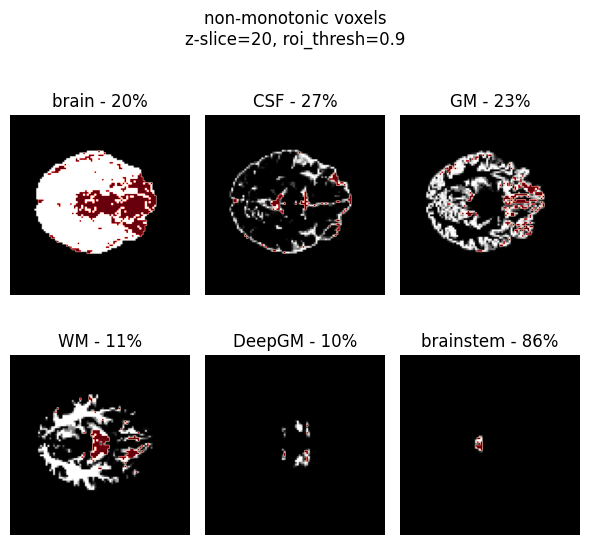

In [26]:
# shape is one less in TE dim because we are calculating diff between each consecutive TE dim
slice = 20
thresh = 0.9

mri_data_diff = np.zeros(shape=(mri_data.shape[0], mri_data.shape[1], mri_data.shape[2], mri_data.shape[3]-1))

for t in range(mri_data_diff.shape[3]):
    img0 = mri_data[:,:,:,t]
    img1 = mri_data[:,:,:,t+1]
    mri_data_diff[:,:,:,t] = img0 - img1
    mri_data_diff_increasing_bool = mri_data_diff < 0
    mri_data_nonmono = np.where(mri_data_diff_increasing_bool.sum(axis=3) > 0, True, False)

signals_segs_nonmono = np.zeros_like(seg_data)
for roi_id in roi_id_dict:
    signals_segs_nonmono[:,:,:,roi_id] = mri_data_nonmono * (seg_data[:,:,:,roi_id] > thresh)



fig, axs = plt.subplots(2,3, figsize=(6,6))
fig.suptitle(f'non-monotonic voxels\nz-slice={slice}, roi_thresh={thresh}')

print(f'using threshold of {thresh} to classify voxels\n')
print(f"{'Region':<12}|{'Total Voxels':<20}|{'Nonmonotonic Voxels':<20}|{'Percentage':<10}")
print(f"{'-'*12}|{'-'*20}|{'-'*20}|{'-'*10}")
for roi_id, ax in enumerate(fig.axes):
    roi = roi_id_dict[roi_id]
    nb_roi = (seg_data[:,:,:,roi_id] > thresh).sum()
    nb_nonmono = signals_segs_nonmono[:,:,:,roi_id].sum()
    pct_nonmono = nb_nonmono / nb_roi
    print(f'{roi:<12}|{nb_roi:20.0f}|{nb_nonmono:20.0f}|{pct_nonmono:10.0%}')
    
    roi = roi_id_dict[roi_id]
    ax.imshow(seg_data[:,:,slice,roi_id], cmap='gray')
    ax.imshow(signals_segs_nonmono[:,:,slice, roi_id], alpha=signals_segs_nonmono[:,:,slice,roi_id], cmap='Reds')
    ax.set_title(f'{roi} - {pct_nonmono:2.0%}')
    ax.set_axis_off()

fig.tight_layout()
fig.show()

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_16108\2660673532.py:32: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


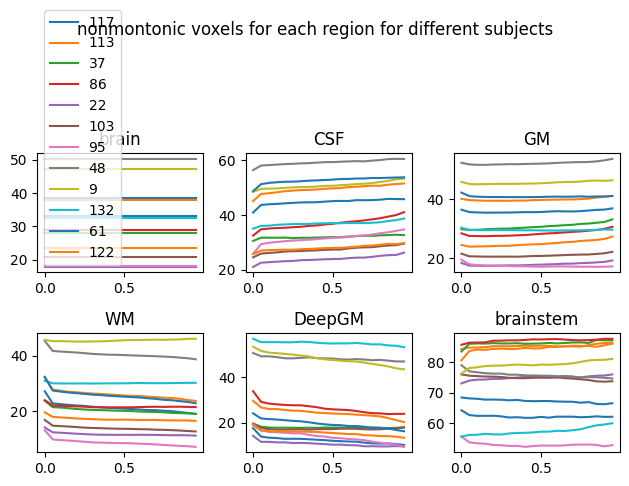

In [20]:
# shape is one less in TE dim because we are calculating diff between each consecutive TE dim
thresh_vals = np.arange(start=0, stop=1, step=0.05)
segs_nonmono_pct = np.zeros(shape=(len(roi_dict), thresh_vals.shape[0]))

random_ids = rng.integers(low=0, high=subject_ids.shape[0], size=12)

fig, axs = plt.subplots(2,3)
fig.suptitle('nonmontonic voxels for each region for different subjects')
for id in random_ids:
    mri_data = data_loader.get_img(id, 'signal')
    mri_data_diff = np.zeros(shape=(mri_data.shape[0], mri_data.shape[1], mri_data.shape[2], mri_data.shape[3]-1))

    for t in range(mri_data_diff.shape[3]):
        img0 = mri_data[:,:,:,t]
        img1 = mri_data[:,:,:,t+1]
        mri_data_diff[:,:,:,t] = img0 - img1
        mri_data_diff_increasing_bool = mri_data_diff < 0
        mri_data_nonmono = np.where(mri_data_diff_increasing_bool.sum(axis=3) > 0, True, False)
        
    for roi_id in roi_id_dict:
        for i, thresh in enumerate(thresh_vals):
            nb_roi = (seg_data[:,:,:,roi_id] > thresh).sum()
            nb_roi_nonmono = (mri_data_nonmono * (seg_data[:,:,:,roi_id] > thresh)).sum()
            segs_nonmono_pct[roi_id, i] = nb_roi_nonmono / nb_roi

    for ax_id, roi_id in enumerate(roi_id_dict):
        roi = roi_id_dict[roi_id]
        fig.axes[ax_id].plot(thresh_vals, segs_nonmono_pct[roi_id] * 100, label=str(id))
        fig.axes[ax_id].set_title(roi)
fig.axes[0].legend()
fig.tight_layout()
fig.show()

In [21]:
# shape is one less in TE dim because we are calculating diff between each consecutive TE dim
subject_seg_nonmono_pct = np.zeros(shape=(subject_ids.shape[0], len(roi_dict)))


for id in tqdm(range(subject_ids.shape[0])):
    mri_data = data_loader.get_img(id, 'signal')
    mri_data_diff = np.zeros(shape=(mri_data.shape[0], mri_data.shape[1], mri_data.shape[2], mri_data.shape[3]-1))

    for t in range(mri_data_diff.shape[3]):
        img0 = mri_data[:,:,:,t]
        img1 = mri_data[:,:,:,t+1]
        mri_data_diff[:,:,:,t] = img0 - img1
        mri_data_diff_increasing_bool = mri_data_diff < 0
        mri_data_nonmono = np.where(mri_data_diff_increasing_bool.sum(axis=3) > 0, True, False)
        
    for roi_id in roi_id_dict:
        nb_roi = (seg_data[:,:,:,roi_id] > thresh_default).sum()
        nb_roi_nonmono = (mri_data_nonmono * (seg_data[:,:,:,roi_id] > thresh_default)).sum()
        subject_seg_nonmono_pct[id,roi_id] = nb_roi_nonmono / nb_roi



100%|██████████| 137/137 [03:22<00:00,  1.48s/it]


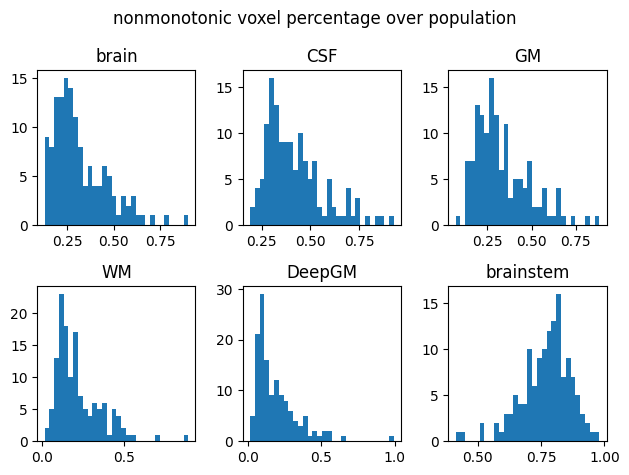

In [22]:
fig, axs = plt.subplots(2, 3)
fig.suptitle('nonmonotonic voxel percentage over population')

for roi_id, ax in enumerate(fig.axes):
    roi = roi_id_dict[roi_id]
    ax.hist(subject_seg_nonmono_pct[:,roi_id], bins=30)
    ax.set_title(roi)
fig.tight_layout()


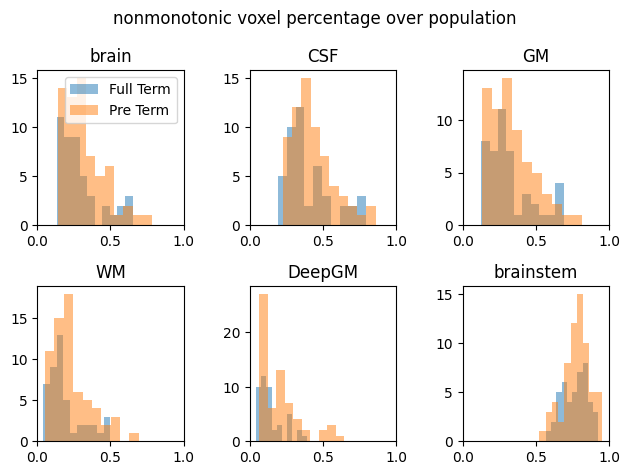

In [23]:
subject_gabs = data_loader.get_info(9)

fig, axs = plt.subplots(2, 3)
fig.suptitle('nonmonotonic voxel percentage over population')

for roi_id, ax in enumerate(fig.axes):
    roi = roi_id_dict[roi_id]
    ax.hist(subject_seg_nonmono_pct[subject_gabs > 30, roi_id], bins=10, alpha=0.5, label='Full Term')
    ax.hist(subject_seg_nonmono_pct[subject_gabs <= 30, roi_id], bins=10, alpha=0.5, label='Pre Term')
    ax.set_xlim(0,1)
    ax.set_title(roi)
    if roi_id == 0:
        ax.legend()
fig.tight_layout()

### Not all images are for all TE times
We have removed data from subjects [43607, 44631, 74067, 78004] due to either data not loading, or not having all TE timings

### Check if voxels are monoexponential
First calculate assuming 1x T2 for each voxel and then plot the ones with highest RMSE

c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:74: RuntimeWarning: divide by zero encountered in divide
  T2 = (-1) / X[:,:,1]
c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:94: RuntimeWarning: divide by zero encountered in divide
  T2_inv = 1/T2


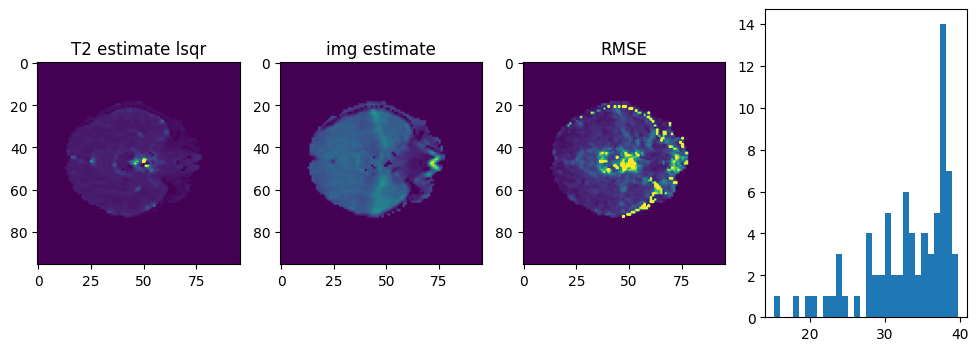

In [24]:
signals_img = mri_data[:,:,slice_default,:]
mask_brain_img = mask_data[:,:,slice_default]

T2_img, S0_img = utils.lsqr_weighted(signals_img, mask_brain_img, TE_times)
signals_est = utils.model_one_compartment(T2=T2_img, S0=S0_img, TE=TE_times)
RMSE = utils.RMSE(signal_actual=signals_img, signal_estimate=signals_est, dim=2)
RMSE = np.where(mask_brain_img==1, RMSE, 0)

fig, axs = plt.subplots(1,4, figsize=(12,4))

RMSE_want_idxs = (RMSE.flatten() < 40) * (RMSE.flatten() > 0)

vmax = [T2_img.max()/15, signals_est.max(), RMSE.max()/5]
axs[0].imshow(T2_img, vmax=vmax[0])
axs[0].set_title('T2 estimate lsqr')
axs[1].imshow(signals_est[:,:,0], vmax=vmax[1])
axs[1].set_title('img estimate')
axs[2].imshow(RMSE, vmax=vmax[2])
axs[2].set_title('RMSE')
axs[3].hist(RMSE.flatten()[RMSE_want_idxs], bins=30)
axs[2].set_title('RMSE')
plt.show()

C:\Users\fl_cl\AppData\Local\Temp\ipykernel_16108\2341560558.py:21: RuntimeWarning: divide by zero encountered in log
  ax.plot(TE_times, np.log(vox_signals.T))


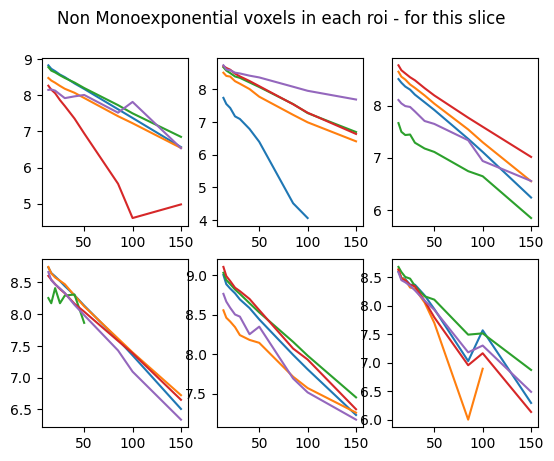

In [25]:
RMSE_thresh = 8
RMSE_segs = []
seg_img = seg_data[:,:,slice_default]
seg_vox_ids = []
for roi_id, roi in enumerate(roi_dict):
    RMSE_seg = np.where(seg_img[:,:,roi_id] > thresh_default, RMSE, 0)
    RMSE_segs.append(np.copy(RMSE_seg))
    vox_over_thresh_idx = np.argwhere(RMSE[RMSE_seg>0].flatten() > 8)
    np.random.shuffle(vox_over_thresh_idx)
    try:
        seg_vox_ids.append(np.squeeze(vox_over_thresh_idx[:nb_rand_vox]))
    except:
        seg_vox_ids.append(vox_over_thresh_idx)

fig, axs = plt.subplots(2,3)

for roi_id, ax in enumerate(fig.axes):
    roi = roi_id_dict[roi_id]
    signals_seg = mri_data[seg_data[:,:,slice_default,roi_id] > thresh_default,slice_default,:]
    vox_signals = signals_seg[seg_vox_ids[roi_id],:]
    ax.plot(TE_times, np.log(vox_signals.T))
fig.suptitle('Non Monoexponential voxels in each roi - for this slice')
plt.show()